In [19]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA


In [21]:
path = "Iris.csv"
if not os.path.exists(path):
    raise FileNotFoundError(f"{path} not found — put Iris.csv in this folder or change 'path'.")

df = pd.read_csv(path)
print("Rows,cols:", df.shape)
print(df.head())   

Rows,cols: (150, 6)
   Id  SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm      Species
0   1            5.1           3.5            1.4           0.2  Iris-setosa
1   2            4.9           3.0            1.4           0.2  Iris-setosa
2   3            4.7           3.2            1.3           0.2  Iris-setosa
3   4            4.6           3.1            1.5           0.2  Iris-setosa
4   5            5.0           3.6            1.4           0.2  Iris-setosa


In [23]:
for c in ["Id", "id", "Index", "Unnamed: 0"]:
    if c in df.columns:
        df = df.drop(columns=[c])

target_col = "Species" if "Species" in df.columns else df.columns[-1]
X_df = df.drop(columns=[target_col])
y_raw = df[target_col].astype(str)

print("Features:", X_df.columns.tolist())
print("Target:", target_col, "| classes:", y_raw.unique())

Features: ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm']
Target: Species | classes: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']


In [25]:
le = LabelEncoder()
y = le.fit_transform(y_raw)
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

X_train_df, X_test_df, y_train, y_test = train_test_split(
    X_df, y, test_size=0.2, random_state=42, stratify=y
)
print("Train / Test sizes:", X_train_df.shape[0], X_test_df.shape[0])

Label mapping: {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}
Train / Test sizes: 120 30


In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_df)
X_test  = scaler.transform(X_test_df)

print("Train mean (approx):", np.round(X_train.mean(axis=0), 3))
print("Train std  (approx):", np.round(X_train.std(axis=0), 3))

Train mean (approx): [-0.  0. -0.  0.]
Train std  (approx): [1. 1. 1. 1.]


In [29]:
knn = KNeighborsClassifier(n_neighbors=initial_k)
knn.fit(X_train, y_train)

y_pred_init = knn.predict(X_test)
acc_init = accuracy_score(y_test, y_pred_init)
print(f"Baseline K={initial_k} test accuracy: {acc_init:.4f}")

print("\nClassification report (baseline):")
print(classification_report(y_test, y_pred_init, target_names=le.classes_))


Baseline K=3 test accuracy: 0.9333

Classification report (baseline):
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.83      1.00      0.91        10
 Iris-virginica       1.00      0.80      0.89        10

       accuracy                           0.93        30
      macro avg       0.94      0.93      0.93        30
   weighted avg       0.94      0.93      0.93        30



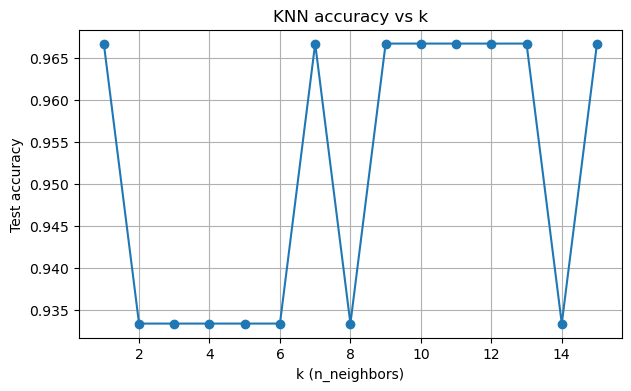

Best k (from this search): 1 -> accuracy = 0.9667


In [31]:
k_list = list(range(1, 16))
accuracies = []

for k in k_list:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, pred))

plt.figure(figsize=(7,4))
plt.plot(k_list, accuracies, marker='o')
plt.xlabel("k (n_neighbors)")
plt.ylabel("Test accuracy")
plt.title("KNN accuracy vs k")
plt.grid(True)
plt.show()

best_k = k_list[int(np.argmax(accuracies))]
print(f"Best k (from this search): {best_k} -> accuracy = {max(accuracies):.4f}")


Final classification report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        10
Iris-versicolor       0.91      1.00      0.95        10
 Iris-virginica       1.00      0.90      0.95        10

       accuracy                           0.97        30
      macro avg       0.97      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



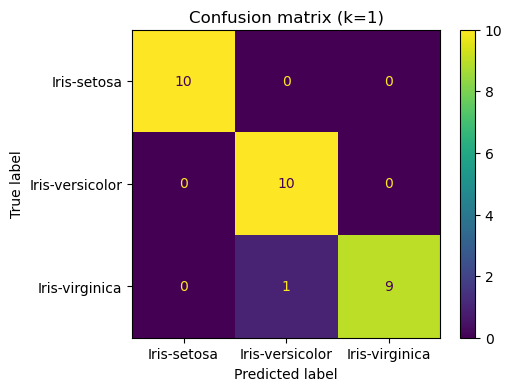

In [33]:
best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(X_train, y_train)
y_pred_best = best_knn.predict(X_test)

print("Final classification report:")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
plt.figure(figsize=(5,4))
disp.plot(ax=plt.gca())
plt.title(f"Confusion matrix (k={best_k})")
plt.show()


Using features: SepalLengthCm and SepalWidthCm for 2D boundary plot


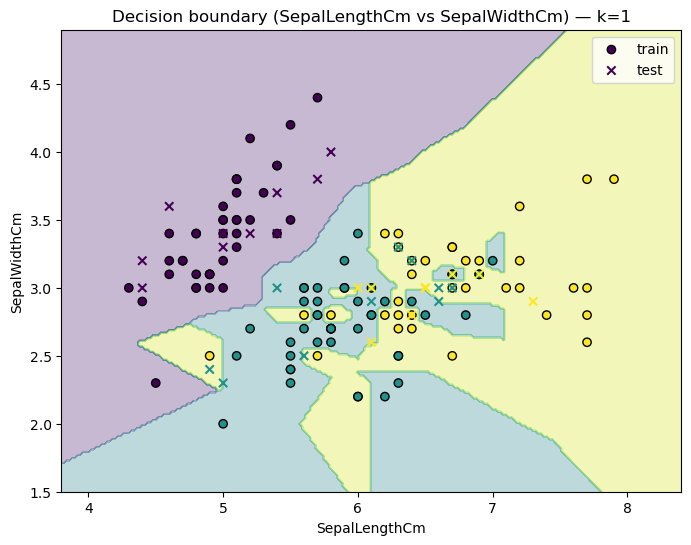

In [35]:
feat1, feat2 = X_df.columns[0], X_df.columns[1]
print("Using features:", feat1, "and", feat2, "for 2D boundary plot")

X2 = df[[feat1, feat2]].values
y2 = le.transform(df[target_col])

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.2, random_state=42, stratify=y2)
sc2 = StandardScaler()
X2_train_s = sc2.fit_transform(X2_train)
X2_test_s  = sc2.transform(X2_test)

knn2 = KNeighborsClassifier(n_neighbors=best_k)
knn2.fit(X2_train_s, y2_train)

x_min, x_max = X2[:,0].min() - 0.5, X2[:,0].max() + 0.5
y_min, y_max = X2[:,1].min() - 0.5, X2[:,1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
grid = np.c_[xx.ravel(), yy.ravel()]
grid_s = sc2.transform(grid)
Z = knn2.predict(grid_s).reshape(xx.shape)

plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X2_train[:,0], X2_train[:,1], c=y2_train, label='train', edgecolor='k')
plt.scatter(X2_test[:,0], X2_test[:,1], c=y2_test, marker='x', label='test')
plt.xlabel(feat1); plt.ylabel(feat2)
plt.title(f"Decision boundary ({feat1} vs {feat2}) — k={best_k}")
plt.legend()
plt.show()


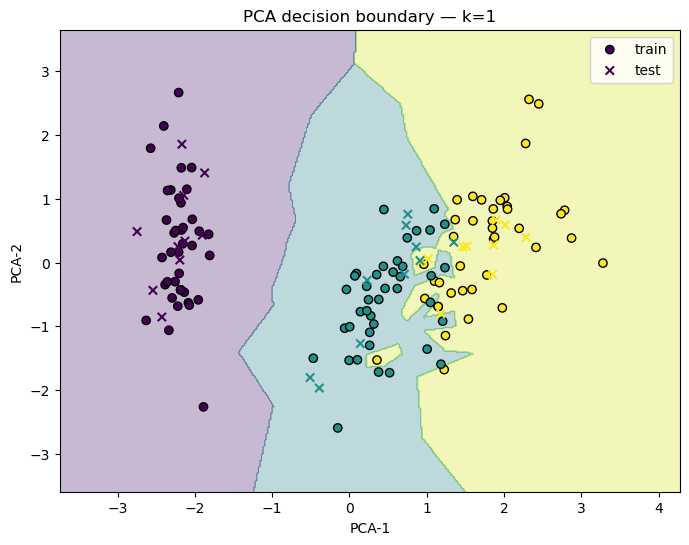

In [37]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(scaler.transform(X_df))  

Xp_train, Xp_test, yp_train, yp_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)
knn_pca = KNeighborsClassifier(n_neighbors=best_k)
knn_pca.fit(Xp_train, yp_train)

x_min, x_max = X_pca[:,0].min() - 1, X_pca[:,0].max() + 1
y_min, y_max = X_pca[:,1].min() - 1, X_pca[:,1].max() + 1
xxp, yyp = np.meshgrid(np.arange(x_min, x_max, 0.02), np.arange(y_min, y_max, 0.02))
gridp = np.c_[xxp.ravel(), yyp.ravel()]
Zp = knn_pca.predict(gridp).reshape(xxp.shape)

plt.figure(figsize=(8,6))
plt.contourf(xxp, yyp, Zp, alpha=0.3)
plt.scatter(Xp_train[:,0], Xp_train[:,1], c=yp_train, edgecolor='k', label='train')
plt.scatter(Xp_test[:,0], Xp_test[:,1], c=yp_test, marker='x', label='test')
plt.xlabel("PCA-1"); plt.ylabel("PCA-2")
plt.title(f"PCA decision boundary — k={best_k}")
plt.legend()
plt.show()
